In [2]:
API_KEY = "YOUR_API_KEY"  # Set up personal Alpaca API key before running the script
SECRET_KEY = "YOUR_SECRET_KEY"
BASE_URL = "https://paper-api.alpaca.markets"
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import importlib
import functions
importlib.reload(functions)
from functions import get_data
from functions import add_lagged_features_classification
import pandas as pd
import numpy as np
import math

In [3]:
# Avoid stocks that have split or changed drasticially recently
tickers = [
    'JPM', 'BAC', 'MS', 'AFL', 'RF',              # Financials
    'JNJ', 'PFE', 'MRK', 'VRTX', 'DVA',           # Health Care
    'AAPL', 'MSFT', 'NVDA', 'ADBE', 'CDW',        # Technology
    'BA', 'GE', 'ETN', 'PCAR', 'ALLE',            # Industrials
    'XOM', 'CVX', 'EOG', 'PSX', 'SLB',            # Energy
    'V', 'NEM', 'IFF', 'ALB', 'PKG',              # Materials
    'AMZN', 'TSLA', 'HD', 'NKE', 'LKQ',           # Consumer Discretionary
    'PG', 'KO', 'WMT', 'KHC', 'CPB',              # Consumer Staples
    'GOOGL', 'META', 'T', 'VZ', 'FOXA',           # Communication Services
    'PLD', 'AMT', 'DLR',                          # Real Estate
    'NEE', 'DUK', 'AEP'                           # Utilities
]

days = 250  #training days

In [4]:
# Retrieve stock data via API
stocks_data = get_data(tickers, days = days)

# Retrieve S&P 500 data via API
sp500_ticker = 'SPY'
sp500_data = get_data(sp500_ticker, days)

# Find S&P 500's daily movement and volume
sp500_data['SPY']['target_sp500'] = sp500_data['SPY']['close'].pct_change().shift(1)

# Add features relative to the general market (S&P500)
for key, df in stocks_data.items():
    df = df.merge(sp500_data['SPY'][['timestamp', 'target_sp500']], on='timestamp')
    stocks_data[key] = df
    
def save_classification_target(data, days):
    stocks_classification_target = {}

    for key, df in data.items():
        pct_change = df['close'].pct_change()
        target = target = pct_change.iloc[-1]
        if target < 0:
            classification = 0
        else:
            classification = 1
        stocks_classification_target[key] = classification

    return stocks_classification_target

# Save classification target for evaluation before adding engineered features
target = save_classification_target(stocks_data, days = days)

# Add lagged features (see other file)
for key in stocks_data:
    stocks_data[key] = add_lagged_features_classification(stocks_data[key])

In [5]:
stocks_data['AAPL']['target']

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
246    0.0
247    1.0
248    1.0
249    0.0
250    NaN
Name: target, Length: 251, dtype: float64

In [6]:
# Ensure there is 251 rows, 250 for training, 1 for testing
stocks_data['AAPL']

,symbol,timestamp,close_lag1,close_lag2,close_lag3,open_lag1,open_lag2,open_lag3,volume_lag1,volume_lag2,...,return_10d,target,relative_return_1d,rolling_corr_10,return_vs_sp500,price_vs_upper_band,price_vs_lower_band,return_skew_5d,stoch_k,price_accel
0,AAPL,2024-07-17 04:00:00+00:00,234.82,234.40,230.54,235.000,236.480,228.920,43234278.0,62631252.0,...,0.083368,0.0,-0.004138,0.783689,0.302098,0.982100,1.165921,-1.683031,0.910509,-3.44
1,AAPL,2024-07-18 04:00:00+00:00,228.88,234.82,234.40,229.450,235.000,236.480,57345884.0,43234278.0,...,0.039088,1.0,-0.011275,0.863539,1.804255,0.953625,1.134679,-1.549324,0.689937,-6.36
2,AAPL,2024-07-19 04:00:00+00:00,224.18,228.88,234.82,230.280,229.450,235.000,66034585.0,57345884.0,...,0.011871,0.0,-0.012850,0.913852,2.672460,0.932916,1.107539,-0.297643,0.515410,1.24
3,AAPL,2024-07-22 04:00:00+00:00,224.31,224.18,228.88,224.820,230.280,229.450,49151453.0,66034585.0,...,-0.008969,1.0,0.007221,0.928264,-0.087338,0.933665,1.099941,-0.306153,0.489530,4.83
4,AAPL,2024-07-23 04:00:00+00:00,223.96,224.31,224.18,227.010,224.820,230.280,48201835.0,49151453.0,...,-0.016943,0.0,-0.011870,0.894477,-0.151330,0.934229,1.086678,-0.008351,0.400361,-0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,AAPL,2025-07-11 04:00:00+00:00,212.41,211.14,210.01,210.505,209.530,210.100,44443634.0,48749367.0,...,0.053830,0.0,0.003195,0.460645,2.132028,0.984682,1.108116,-0.199348,0.802839,0.14
247,AAPL,2025-07-14 04:00:00+00:00,211.16,212.41,211.14,210.565,210.505,209.530,39765812.0,44443634.0,...,0.050547,1.0,-0.002369,0.471785,1.674501,0.975156,1.099229,-1.953915,0.706427,-2.52
248,AAPL,2025-07-15 04:00:00+00:00,208.62,211.16,212.41,209.925,210.565,210.505,38840111.0,39765812.0,...,0.037498,1.0,-0.013937,0.667468,-6.300392,0.961800,1.082760,-1.066145,0.551543,-1.29
249,AAPL,2025-07-16 04:00:00+00:00,209.11,208.62,211.16,209.220,209.925,210.565,42296339.0,38840111.0,...,0.019204,0.0,0.006622,0.642989,-0.549767,0.963571,1.078830,-0.618324,0.580419,3.03


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def classify_stocks_random_forest_classifier(data, days, threshold = 0.45):
   
    stock_predictions = {}

    for key, df in data.items():
        features = [col for col in df.columns if col not in ['symbol', 'timestamp', 'target']]

        X = df[features].values
        y = df['target'].values

        if len(X) <= days:
            continue  # Not enough data

        X_train = X[:days]
        y_train = y[:days]
        X_test = X[days:days + 1]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=10,
        random_state=42,
        class_weight='balanced'
        )
        model.fit(X_train_scaled, y_train)

        # Use predict_proba and apply custom threshold
        prob = model.predict_proba(X_test_scaled)[0][1]  # Probability of class '1'
        prediction = int(prob >= threshold)
        stock_predictions[key] = prediction

    return stock_predictions

In [8]:
# Predict
stocks_predictions = classify_stocks_random_forest_classifier(stocks_data, days = days)

In [9]:
# Evaluate accuracy
def evaluate_predictions(predictions, targets):
    correct = 0
    total = len(targets)

    for key in targets:
        if key in predictions:
            if predictions[key] == targets[key]:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy:.2%} ({correct}/{total})")
    return accuracy
accuracy = evaluate_predictions(stocks_predictions, target)
accuracy

Accuracy: 60.78% (31/51)


0.6078431372549019

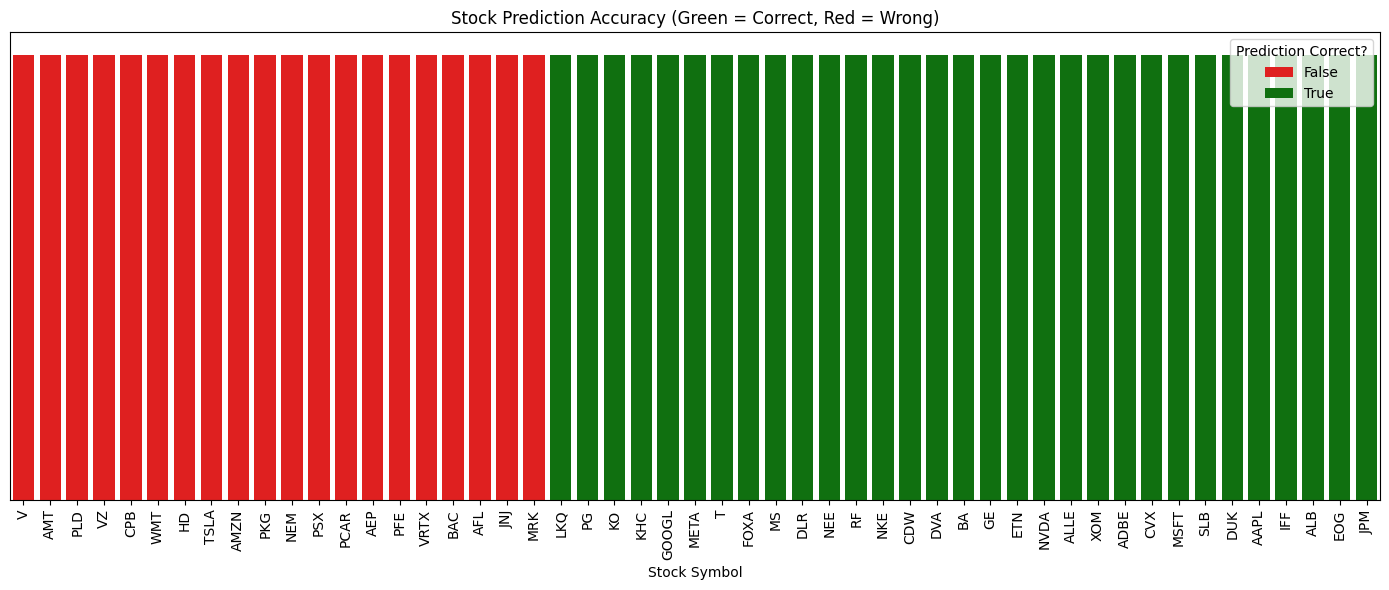

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
stock_names = list(stocks_predictions.keys())
y_pred = [stocks_predictions[stock] for stock in stock_names]
y_true = [target[stock] for stock in stock_names]

df_results = pd.DataFrame({
    'Stock': stock_names,
    'True': y_true,
    'Predicted': y_pred
})
df_results['Correct'] = df_results['True'] == df_results['Predicted']

# Sort by correctness to make it visually informative
df_results.sort_values(by='Correct', inplace=True)

# Plot: each stock is a bar, colored by prediction correctness
plt.figure(figsize=(14, 6))
sns.barplot(x='Stock', y=[1]*len(df_results), hue='Correct', dodge=False, data=df_results, palette={True: 'green', False: 'red'})
plt.xticks(rotation=90)
plt.yticks([])
plt.title("Stock Prediction Accuracy (Green = Correct, Red = Wrong)")
plt.xlabel("Stock Symbol")
plt.ylabel("")
plt.legend(title="Prediction Correct?")
plt.tight_layout()
plt.show()

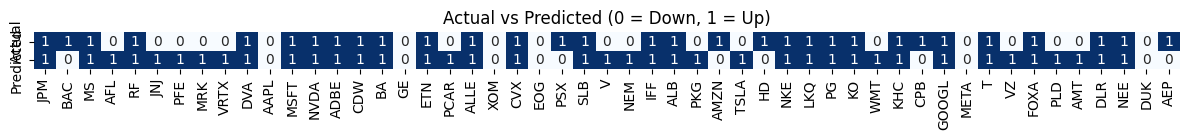

In [11]:
# Heatmap of actual vs predicted
plt.figure(figsize=(12, 1.5))
sns.heatmap([y_true, y_pred], cmap="Blues", cbar=False, annot=True, fmt='d',
            xticklabels=stock_names, yticklabels=["Actual", "Predicted"])
plt.xticks(rotation=90)
plt.title("Actual vs Predicted (0 = Down, 1 = Up)")
plt.tight_layout()
plt.show()

In [12]:
# Function that finds and visualizes feature importance

def show_feature_importance(model, feature_names, top_n=None):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df)

    # Visualize
    if top_n:
        feature_importance_df = feature_importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

                Feature  Importance
7           volume_lag2    0.036476
6           volume_lag1    0.035365
29   relative_return_1d    0.035363
31      return_vs_sp500    0.034684
21        volume_avg_10    0.034145
23    volume_change_pct    0.032563
18        price_vs_sma5    0.031302
16               std_10    0.030448
34       return_skew_5d    0.030218
5             open_lag3    0.030103
8           volume_lag3    0.029820
30      rolling_corr_10    0.027896
9             return_1d    0.027696
22         volume_spike    0.027679
20        price_vs_vwap    0.027453
0            close_lag1    0.026772
11                  gap    0.026749
36          price_accel    0.026570
17               ema_26    0.026059
19       price_vs_sma10    0.025926
32  price_vs_upper_band    0.025749
27               RSI_14    0.025646
24           range_lag1    0.025177
2            close_lag3    0.025005
1            close_lag2    0.024734
28           return_10d    0.024486
35              stoch_k    0

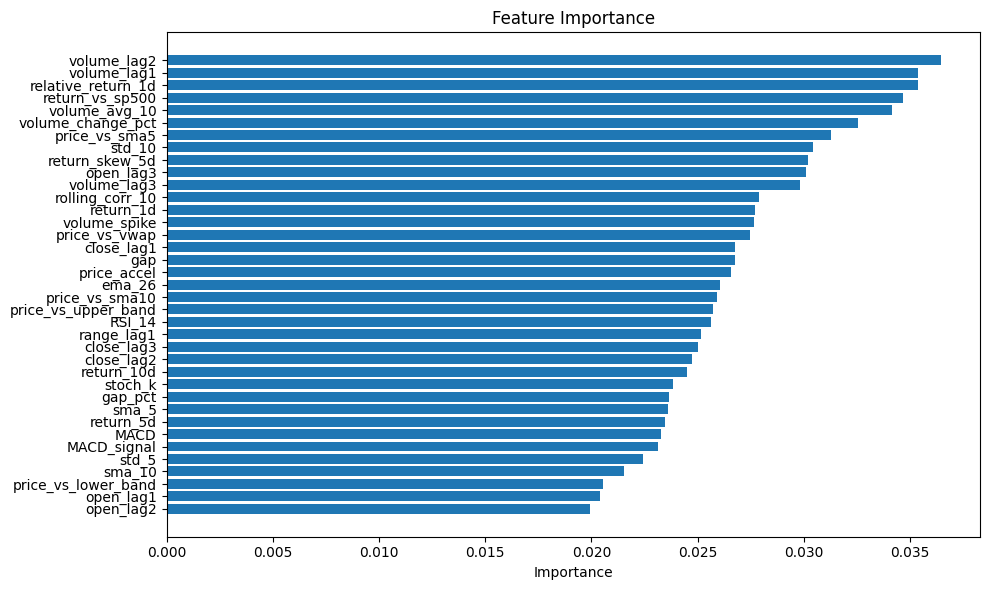

In [13]:
for key, df in stocks_data.items():
     
        features = [col for col in df.columns if col not in ['symbol', 'timestamp', 'target']]

        X = df[features].values
        y = df['target'].values

        X_train = X[:days]
        y_train = y[:days]
        X_test = X[days:days + 1]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Show feature importances
show_feature_importance(model, features)